In [1]:
from __future__ import absolute_import, print_function,division, unicode_literals

import os.path
import glob
import shutil

import tensorflow as tf
assert tf.__version__.startswith('2')

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,Flatten,MaxPooling2D,Dropout,Dense,Activation
from keras import regularizers
import keras

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib

In [3]:
print(tf.__version__)

2.3.1


In [7]:
BATCH_SIZE = 64
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [4]:
data_dir ="Downloads/Images"
data_dir = pathlib.Path(data_dir)

CLASS_NAMES = np.array(['Backmoth','Leafminer','Mildew'])

print('Class Names: ', CLASS_NAMES)

Class Names:  ['Backmoth' 'Leafminer' 'Mildew']


In [5]:
#Group into train, test and validation sets
for cl in CLASS_NAMES:
    data_path = os.path.join(data_dir, cl)
    images = glob.glob(data_path + "/*")
    print("{} :{} ".format(cl,len(images)))
    train, val = images[:round(len(images)*0.8)],images[round(len(images)*0.8):]
    
    for t in train:
        if not os.path.exists(os.path.join(data_dir, 'train', cl)):
            os.makedirs(os.path.join(data_dir, 'train', cl))
        shutil.move(t,os.path.join(data_dir, 'train', cl))
        
    for v in val:
        if not os.path.exists(os.path.join(data_dir, 'val', cl)):
            os.makedirs(os.path.join(data_dir, 'val', cl))
        shutil.move(v,os.path.join(data_dir, 'val', cl))
    
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

Backmoth :0 
Leafminer :0 
Mildew :0 


In [8]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    zoom_range=0.50,
     rotation_range=45,
    horizontal_flip=True,
     width_shift_range=0.15,
 height_shift_range=0.15,
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, 
    subset='training')#set as training

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, 
    subset='validation')#set as validation

Found 192 images belonging to 3 classes.
Found 12 images belonging to 3 classes.


In [34]:
def plotImages(img_arr):
    fig,axes = plt.subplots(1, 5,  figsize = (25, 25))
    axes = axes.flatten()
    for img, ax in zip(img_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

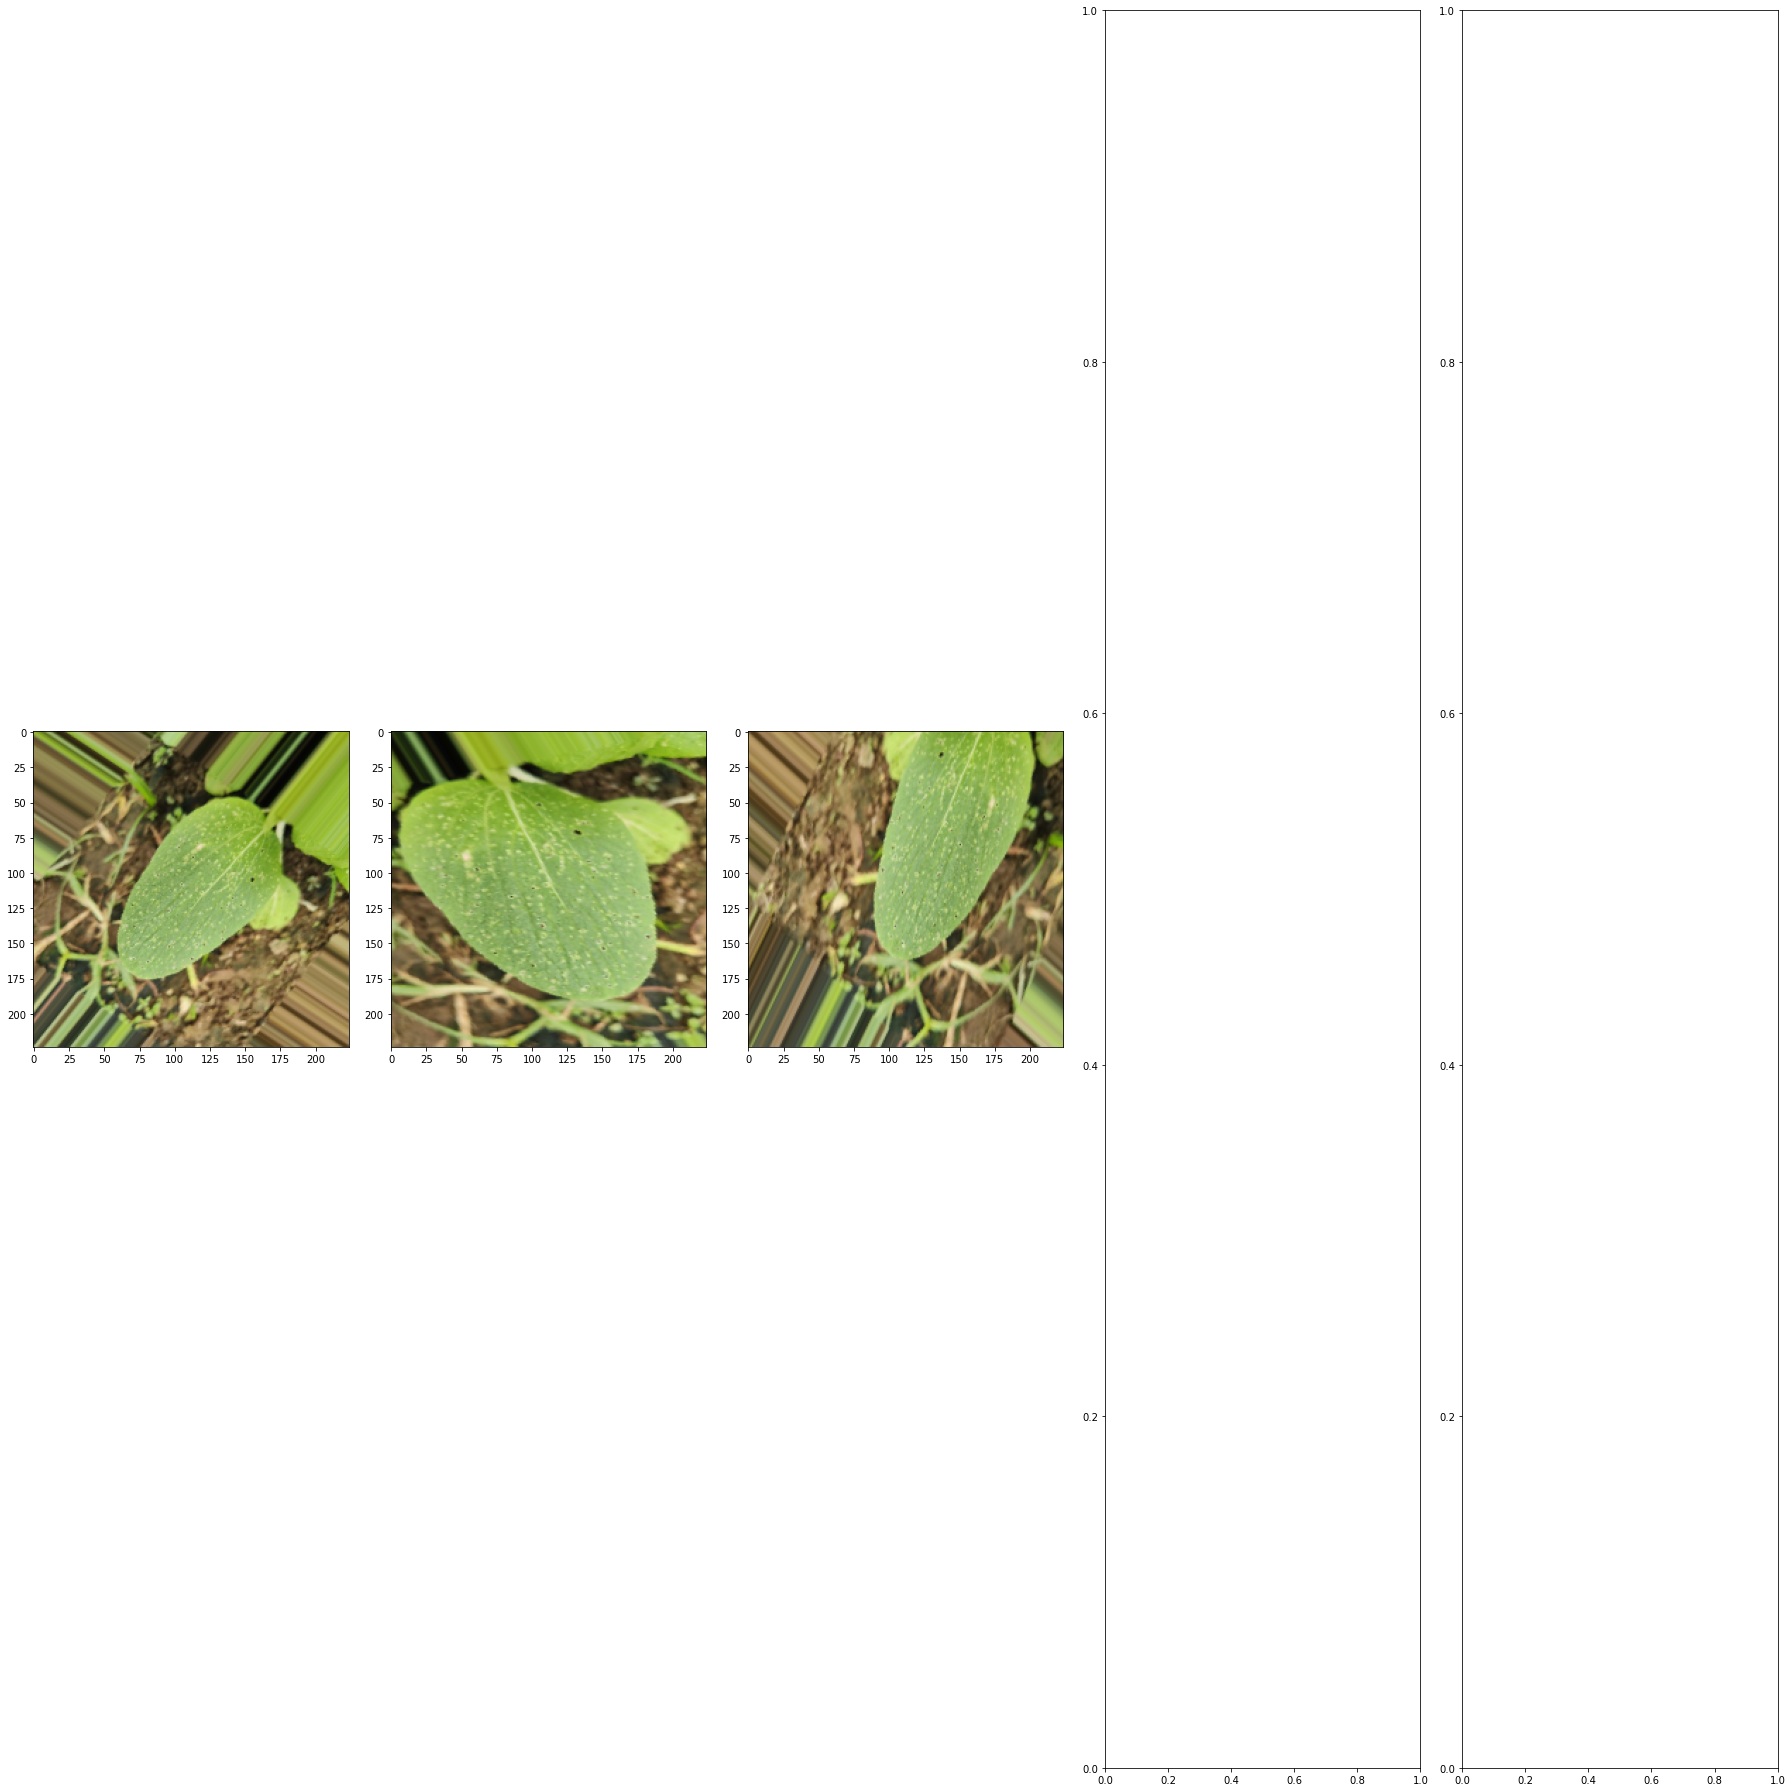

In [35]:
#plot a few train images
img_array = [train_generator[0][0][0] for i in range(3)]
plotImages(img_array)

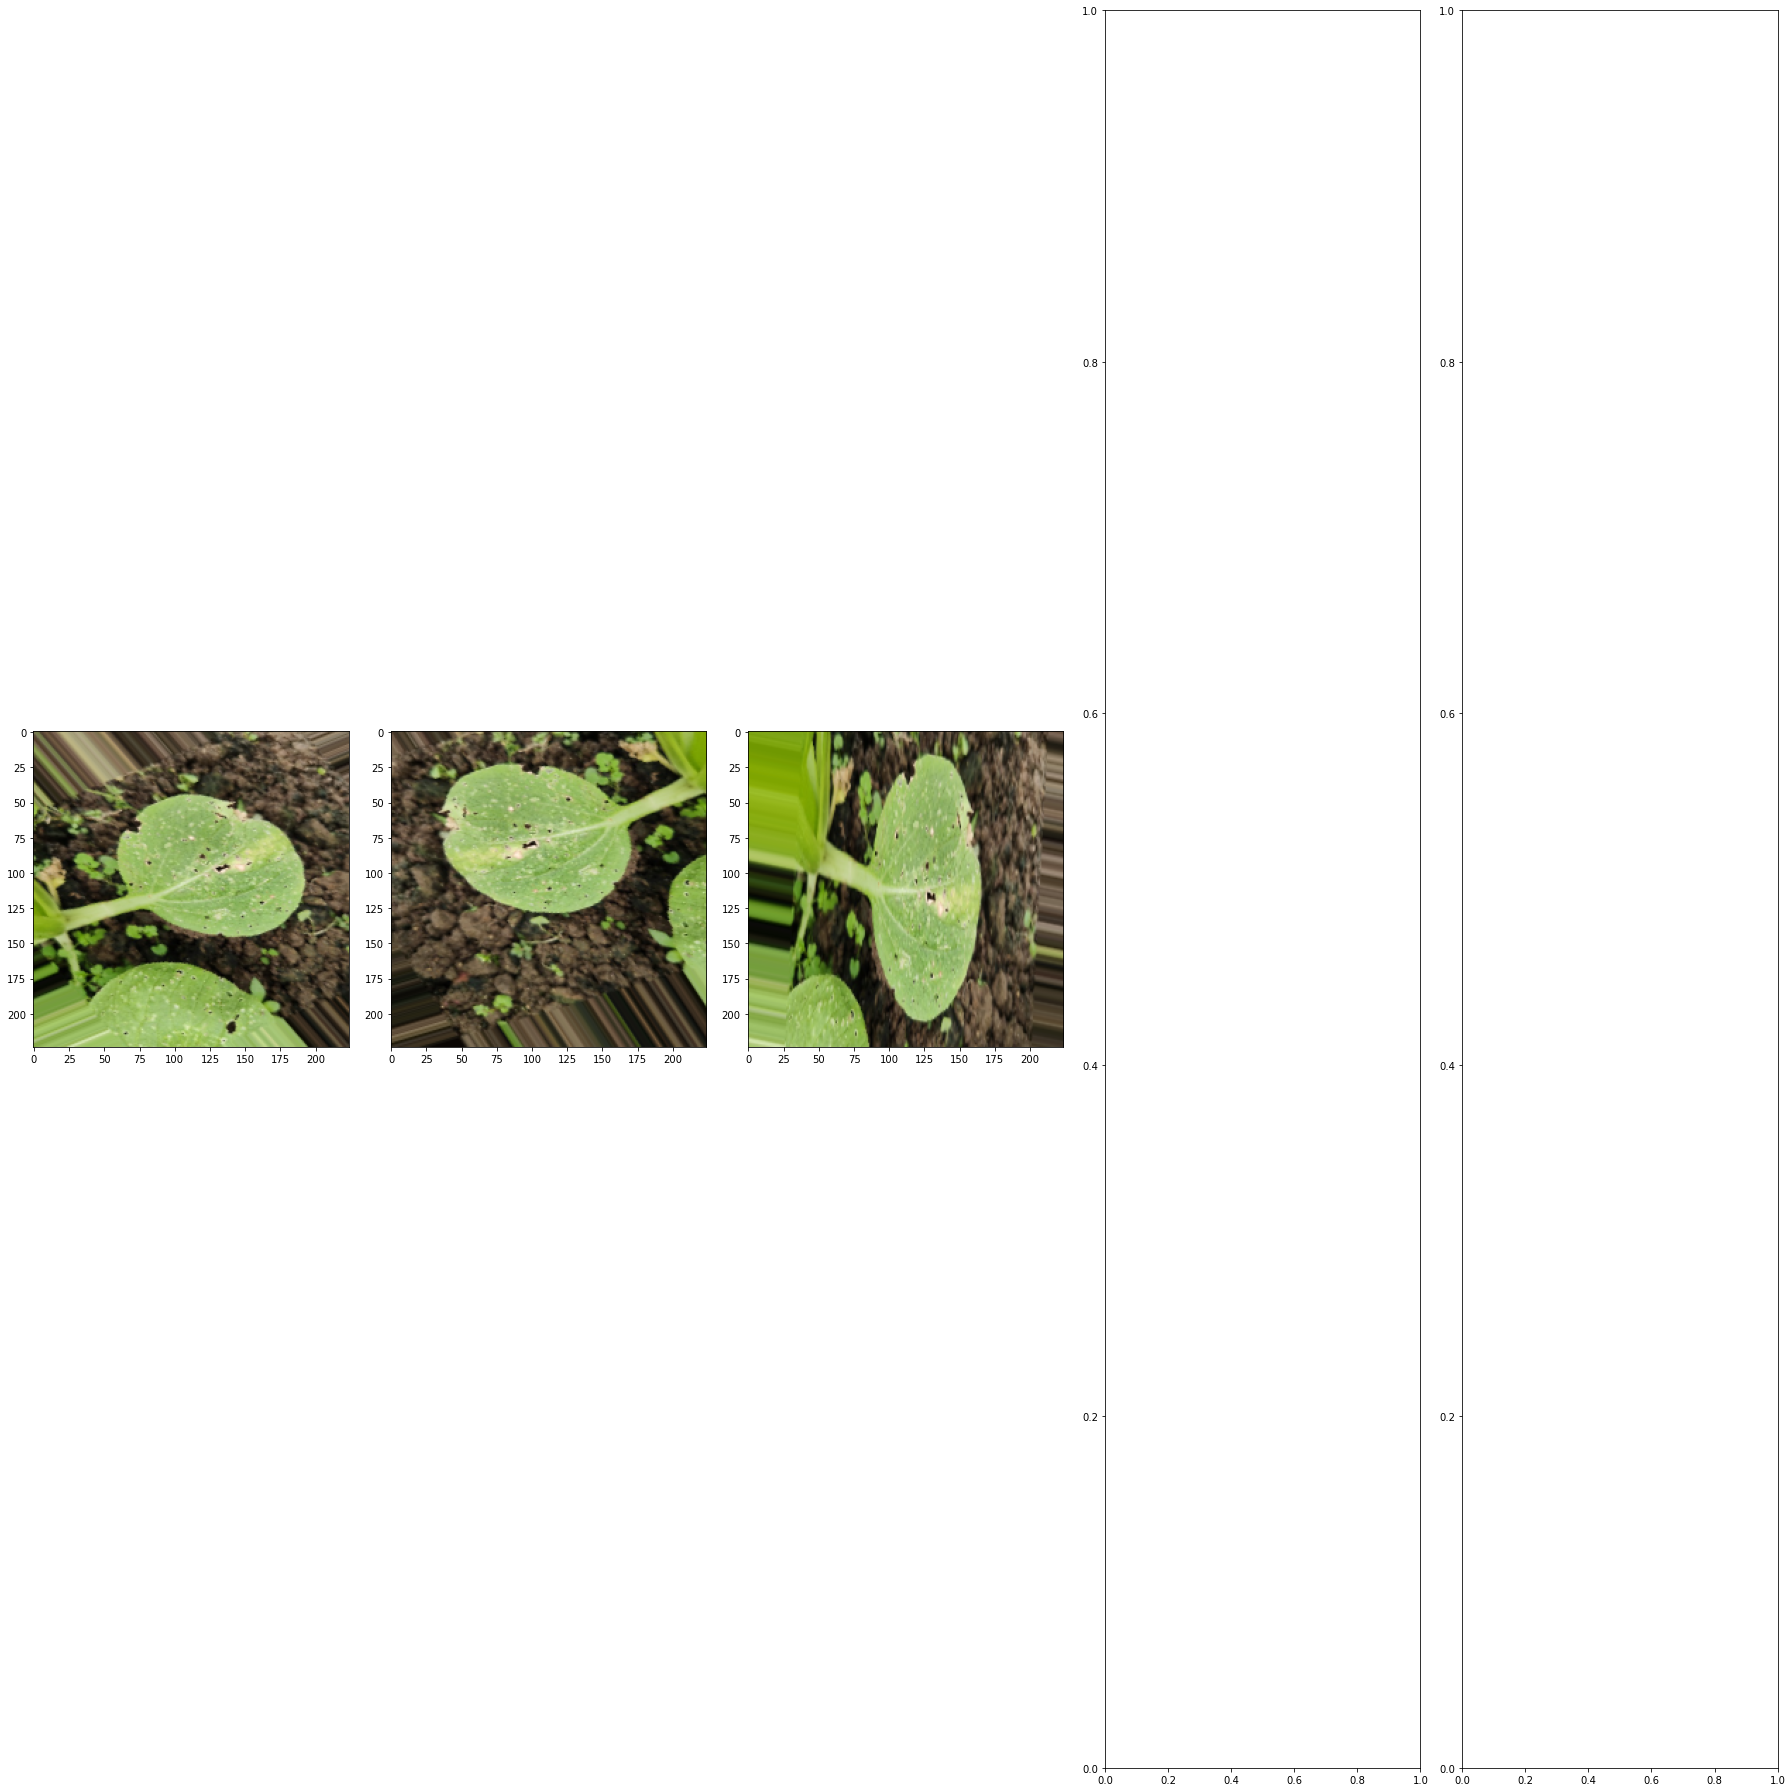

In [36]:
# plot a few val images
img_array  = [val_generator[0][0][0] for i in range(3)]
plotImages(img_array)

In [37]:
IMG_SHAPE = (IMG_HEIGHT,IMG_WIDTH,3)

In [38]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

In [39]:
base_model.trainable = False

In [40]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(3, activation='softmax')
])

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 2,626,755
Trainable params: 368,771
Non-trainable params: 2,257,984
_________________________________________________________________


In [42]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [43]:
epochs = 10

history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=epochs, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator))

Epoch 1/10
3/3 [==============================] - 9s 3s/step - loss: 6.8671 - accuracy: 0.3229 - val_loss: 3.3702 - val_accuracy: 0.5000
Epoch 2/10
3/3 [==============================] - 7s 2s/step - loss: 1.7281 - accuracy: 0.4635 - val_loss: 1.7764 - val_accuracy: 0.3333
Epoch 3/10
3/3 [==============================] - 7s 2s/step - loss: 1.0641 - accuracy: 0.4740 - val_loss: 1.0099 - val_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - 7s 2s/step - loss: 0.8699 - accuracy: 0.5833 - val_loss: 1.0692 - val_accuracy: 0.3333
Epoch 5/10
3/3 [==============================] - 9s 3s/step - loss: 0.9885 - accuracy: 0.4531 - val_loss: 0.9783 - val_accuracy: 0.4167
Epoch 6/10
3/3 [==============================] - 8s 3s/step - loss: 0.8620 - accuracy: 0.5365 - val_loss: 0.7910 - val_accuracy: 0.7500
Epoch 7/10
3/3 [==============================] - 8s 3s/step - loss: 0.8060 - accuracy: 0.6458 - val_loss: 0.8595 - val_accuracy: 0.7500
Epoch 8/10
3/3 [=========================

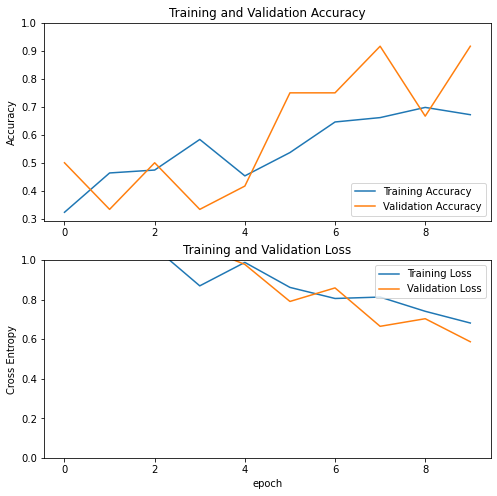

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [45]:
### Fine Tuning The model

In [46]:
base_model.trainable = True

In [47]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(3, activation='softmax')
])

In [48]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [49]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [50]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 2,626,755
Trainable params: 2,231,363
Non-trainable params: 395,392
_________________________________________________________________


In [51]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 60


In [52]:
epochs= 10

history_fine = model.fit(train_generator, 
                         steps_per_epoch=len(train_generator), 
                         epochs=epochs, 
                         validation_data=val_generator, 
                         validation_steps=len(val_generator))

Epoch 1/10
3/3 [==============================] - 17s 6s/step - loss: 1.2908 - accuracy: 0.3229 - val_loss: 1.1918 - val_accuracy: 0.3333
Epoch 2/10
3/3 [==============================] - 15s 5s/step - loss: 1.1156 - accuracy: 0.4115 - val_loss: 1.1111 - val_accuracy: 0.3333
Epoch 3/10
3/3 [==============================] - 15s 5s/step - loss: 1.0030 - accuracy: 0.4792 - val_loss: 1.4344 - val_accuracy: 0.0833
Epoch 4/10
3/3 [==============================] - 16s 5s/step - loss: 0.9846 - accuracy: 0.4948 - val_loss: 1.2177 - val_accuracy: 0.0833
Epoch 5/10
3/3 [==============================] - 16s 5s/step - loss: 0.8785 - accuracy: 0.6094 - val_loss: 1.0410 - val_accuracy: 0.4167
Epoch 6/10
3/3 [==============================] - 17s 6s/step - loss: 0.8182 - accuracy: 0.5990 - val_loss: 1.0951 - val_accuracy: 0.3333
Epoch 7/10
3/3 [==============================] - 16s 5s/step - loss: 0.7260 - accuracy: 0.6771 - val_loss: 1.1442 - val_accuracy: 0.3333
Epoch 8/10
3/3 [==================

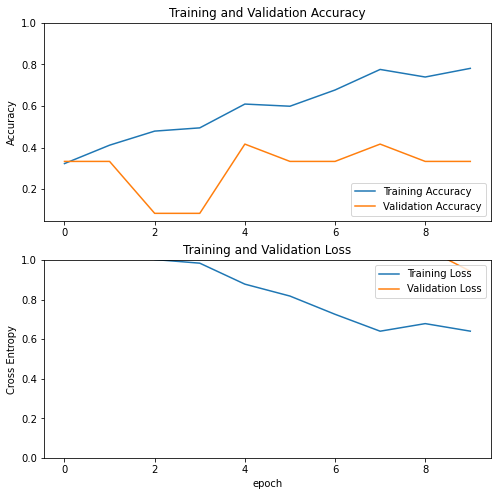

In [59]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [57]:
#optimize the model for inference
mode = "default"

if mode == 'Storage':
  optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
  optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
  optimization = tf.lite.Optimize.DEFAULT
  
optimization

<Optimize.DEFAULT: 'DEFAULT'>

In [58]:
# Save the model TFLite
export_dir = 'saved_model/1'

tf.saved_model.save(model, export_dir)


INFO:tensorflow:Assets written to: saved_model/1\assets


In [60]:
# Convert saved model
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [optimization]
tflite_model = converter.convert()

In [62]:
# Save the converted model tflite file
tflite_model_file = 'model.tflite'

with open(tflite_model_file, 'wb') as f:
    f.write(tflite_model)

with open('labels.txt', 'w') as f:
  f.write('\n'.join(CLASS_NAMES))


In [63]:
# Test the TFLITE model
interpretor = tf.lite.Interpreter(model_content=tflite_model)
interpretor.allocate_tensors()

#details
input_index = interpretor.get_input_details()[0]["index"]
output_index = interpretor.get_output_details()[0]["index"]

In [64]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2] == CLASS_NAMES

def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [67]:
test_batches = tf.data.Dataset.list_files(str(data_dir/'train/*/*'))

test_batches = test_batches.map(process_path).batch(1).prefetch(1)

for img, label in test_batches.take(15):
  interpretor.set_tensor(input_index, img)
  interpretor.invoke()
  predict = interpretor.get_tensor(output_index)
  print("Predicted: {} - {:2.0f}% : True: {}".format(CLASS_NAMES[np.argmax(predict)],
                                                     100*np.max(predict),
                                                     CLASS_NAMES[label[0].numpy()==1]))


TypeError: only integer scalar arrays can be converted to a scalar index

In [68]:
from PIL import Image

for index, (image, label) in enumerate(test_batches.take(5)):
  image = tf.cast(image * 255.0, tf.uint8)
  image = tf.squeeze(image).numpy()
  pil_image = Image.fromarray(image)
  pil_image.save('{}/test_images/{}_{}.jpg'.format(data_dir,CLASS_NAMES[label[0].numpy()==1][0].lower(), index))

TypeError: only integer scalar arrays can be converted to a scalar index